Start by generating the data

(0.0, 20.0)

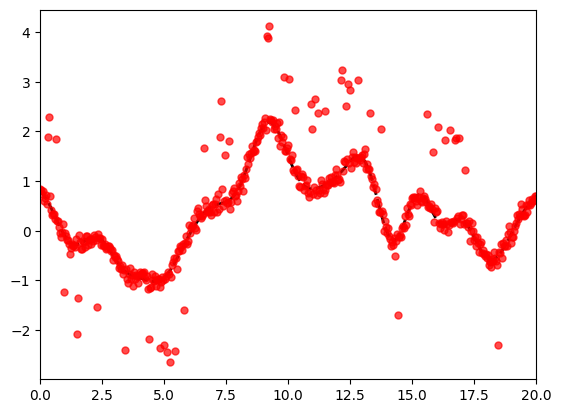

In [1]:
from typing import Optional, Any

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random

from numpy.lib.twodim_base import histogram2d
from tensorboard.plugins.histogram.summary import histogram
from tensorflow.python.ops.variables import trainable_variables

import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 500
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

upp=2
low=1
y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(low, upp, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

Altamirano loss

In [43]:
from sklearn.model_selection import train_test_split
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import w 


class GVI_RCGP_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, Kernel, objective="GVI", Sigma_f_structure="c_f",weightfunction=w.IMQ,C=1,
                 lambda_method="constant", inducing=[.0], alpha=0.5,
                 sigma=.25,test_size=0.15):
        super().__init__()
        self.X = X
        self.y = y

        # define if we are gonna optimize through the GVI or predictive.
        self.objective = objective
        self.alpha = gpflow.Parameter(alpha, trainable=False)
        if objective == "GVI":
            self.sigma = gpflow.Parameter(sigma, trainable=False)
        else:
            self.sigma = gpflow.Parameter(1., transform=gpflow.utilities.positive(), trainable=True)
        # define the weight
        self.weightfunction = weightfunction(C=C)
        
        self.test_size=test_size
        # GP parameters
        self.kernel = Kernel
        self.inducing_variable = inducing

        # set structure for \Sigma_f
        if Sigma_f_structure == "c_f":
            self.c_f = gpflow.Parameter(1., transform=gpflow.utilities.positive(), trainable=True)
        else:
            self.Kernel_inducing = gpflow.kernels.SquaredExponential(lengthscales=0.1, variance=0.1)
        self.Sigma_f_structure = Sigma_f_structure

        # set lambda
        if lambda_method == "constant":
            self.lambda_i = tf.constant(1., dtype=tf.float64)
        elif lambda_method == "predictive" and objective == "predictive":
            self.lambda_i = gpflow.Parameter(1., transform=gpflow.utilities.positive(), trainable=True,
                                             dtype=tf.float64)
        else:
            print("lambda method unknown")
        self.lambda_method = lambda_method

    tf.keras.backend.set_floatx('float64')

    # needed for the class
    def maximum_log_likelihood_objective(self):
        pass

    # update Sigma_f according to method.
    @tf.function
    def compute_sigma_f(self, X,J_w):
        if self.Sigma_f_structure == "c_f":
            K = self.kernel(X, X)
            Sigma_f = self.c_f * K @ tf.linalg.inv(
                    K + self.sigma ** 2 / self.lambda_i * J_w) @J_w * self.sigma ** 2 / self.lambda_i
        else:
            K = self.kernel(X, X)
            K_uu = self.Kernel_inducing(self.inducing_variable, self.inducing_variable)
            K_uf = self.Kernel_inducing(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)
            K_uu_inv = tf.linalg.inv(K_uu + tf.linalg.eye(K_uu.shape[0], dtype=tf.float64) * gpflow.default_jitter())
            Sigma_f = K_fu @ K_uu_inv @ K_uf
        return K, Sigma_f

    @tf.function
    def train_step(self):
        if self.objective == "GVI":
            loss = self.GVI_step()
        else:
            loss = self.Pred_step()
        return loss
    
    def compute_weights(self,X,y):
        W_y=self.weightfunction.W(X,y)
        m_y=self.weightfunction.dy(X,y)**2
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, -2)))*self.sigma**2
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, 2)))/self.sigma**2
        return m_y,J_w,J_w_inv


    def pred_log_prob(self, y, mu_f, sigma_y):
        # ensure 1-D vectors and float64 (gpflow/TensorFlow prefer float64 in many setups)
        y = tf.reshape(tf.cast(y, tf.float64), [-1])
        mu_f = tf.reshape(tf.cast(mu_f, tf.float64), [-1])
        sigma_y = tf.cast(sigma_y, tf.float64)

        # If sigma_y is a full covariance matrix, take diagonal (marginal variances)
        if sigma_y.shape.ndims == 2 and sigma_y.shape[0] == sigma_y.shape[1]:
            var = tf.linalg.diag_part(sigma_y)
        else:
            var = tf.reshape(sigma_y, [-1])


        # quadratic term (scalar)
        term_quad = 0.5 * tf.reduce_sum((y - mu_f) ** 2 / var)

        # log-determinant / normalizer term (scalar)
        term_log = 0.5 * tf.reduce_sum(tf.math.log(var))

        # optional extra term you had: make sure to treat self.sigma numerically
        try:
            inv_sigma2 = tf.math.reciprocal(tf.square(tf.cast(self.sigma, tf.float64)))
        except Exception:
            inv_sigma2 = tf.constant(0.0, dtype=tf.float64)

        term3 = 0.5 * inv_sigma2 * tf.reduce_sum(var + tf.square(tf.cast(self.sigma, tf.float64)))

        return term_quad + term_log + term3

    def GVI_step(self):
        #update weights
        m_y,J_w,J_w_inv=self.compute_weights(self.X,self.y)
        K, Sigma_f = self.compute_sigma_f(self.X,J_w)

        N = tf.cast(tf.shape(K)[0], tf.float64)
        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        

        
        #compute matrixes
        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        
        #update mu
        q1 = self.alpha*Sigma_a@tf.linalg.inv(self.alpha * Sigma_a + J_w*self.lambda_i)
        mu_f = tf.matmul(q1, (self.y-m_y))

        # Log-determinants
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
        ld_K = tf.linalg.logdet(K + jitter)


        term1 = (tf.transpose(mu_f)@J_w_inv@mu_f
               +tf.linalg.trace(Sigma_f@J_w_inv)
               -2*tf.transpose(mu_f)@J_w_inv@(self.y-m_y))
        term2 = 0.5 * self.alpha * tf.transpose(mu_f) @ (Sigma_a_inv) @ (mu_f)
        term3 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
        loss = tf.squeeze(term1 + term2 + term3)
        
        self.sigma.assign(tf.squeeze(tf.sqrt(tf.transpose(y-mu_f-m_y)@J_w_inv@(y-mu_f-m_y)/tf.reduce_sum(J_w_inv))))
        return loss

    def Pred_step(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=0)
        
        
        #define weights and select with the same indexes
        m_y_train,J_w_train,J_w_inv_train=self.compute_weights(X_train,y_train)

        K, Sigma_f = self.compute_sigma_f(X_train,J_w_train)

        N = tf.cast(tf.shape(K)[0], tf.float64)

        eye = tf.eye(N, dtype=K.dtype)
        jitter = eye * 1e-6
        K_inv = tf.linalg.inv(K + jitter)

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f

        q1 = self.alpha*Sigma_a@tf.linalg.inv(self.alpha * Sigma_a + J_w_train*self.lambda_i)
        mu_f = tf.matmul(q1, (y_train-m_y_train))

        K_star = self.kernel(X_test, X_train)
        K_star_star = self.kernel(X_test, X_test)

        mu_p = K_star @ K_inv @ mu_f
        A = K_star_star - K_star @ K_inv @ tf.transpose(K_star) \
            + K_star @ K_inv @ Sigma_f @ tf.transpose(K_star @ K_inv)

        # use diagonal of covariance directly
        sigma_p = tf.linalg.diag_part(A)  # no inverse here

        
        var_y = sigma_p + tf.cast(self.sigma ** 2, tf.float64)
        term1 = self.pred_log_prob(y_test, mu_p, var_y)

        return term1


    def sample_y(self, n_samples=100):
        N = self.X.shape[0]
        f = np.random.multivariate_normal(mean=tf.squeeze(self.mu_f), cov=self.Sigma_f, size=n_samples)  # put the
        noise = tf.random.normal(
                shape=(n_samples, N),
                mean=0.0,
                stddev=self.sigma,  # can be Parameter/Variable
                dtype=tf.float64
            )
        return f + noise

    def predict_ins(self):
        m_y,J_w,J_w_inv=self.compute_weights(self.X,self.y)
        K, Sigma_f = self.compute_sigma_f(self.X,J_w)

        Sigma_a = self.alpha * K + (1.0 - self.alpha) * Sigma_f
        q1 = self.alpha*Sigma_a@tf.linalg.inv(self.alpha * Sigma_a + J_w*self.lambda_i)
        mu_f = tf.matmul(q1, (self.y-m_y))
        self.mu_f = mu_f
        self.Sigma_f = Sigma_f
        self.K = K

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.train_step, self.trainable_variables)

    def predict_out(self, X):
        K_xold_xold = self.kernel(self.X, self.X)
        K_xold_xnew = self.kernel(X, self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)

        #compute variance
        f_var = self.kernel(X,X) - K_xold_xnew @ K_inv @ tf.transpose(K_xold_xnew)+ K_xold_xnew @ K_inv @ self.Sigma_f @ K_inv @ tf.transpose(K_xold_xnew)
        return K_xold_xnew @ K_inv @ self.mu_f, tf.linalg.diag_part(f_var)

    def compute_lambda_stat(self, n_samples=100):
        # sample_y returns (n_samples, N)
        y_sampl = self.sample_y(n_samples)  # (n_samples, N)
        mu = tf.reshape(self.mu_f, [-1])  # (N,)
        variance = tf.linalg.diag_part(self.Sigma_f)
        variance += self.sigma ** 2
        # per-sample mean squared error (one scalar per sampled function)
        s = tf.reduce_mean((y_sampl - tf.reshape(mu, [1, -1])) ** 2 / variance, axis=1)  # (n_samples,)
        # scalar mean squared residual on training data
        y_vec = tf.reshape(self.y, [-1])  # (N,)
        s_mean = tf.reduce_mean((y_vec - mu) ** 2 / variance)  # scalar

        return tf.reduce_mean(tf.cast(s < s_mean, tf.float32))

    def pp_alg(self,lambda_values = [1., 0.1, 0.5, 0.7, 0.8, 0.9, 1.1, 1.2, 1.5, 2., 10.]):
        test_values = []
        for lambda_i in lambda_values:
            self.lambda_i = lambda_i
            self.internal_opt()
            self.predict_ins()
            test_values.append(self.compute_lambda_stat())

        ##choose lambda with best
        self.lambda_i = lambda_values[test_values.index(min(test_values))]
        ##fit model with that lambda
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.train_step, self.trainable_variables)


Test the RCGP alpha

In [44]:
N=X.shape[0]
Z =X[np.random.choice(N, 20, replace=False), :]
kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_RCGP_alpha(X,y,kernel)
model.internal_opt()
model.predict_ins()
tf.reduce_mean((model.mu_f - f) ** 2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.010156008550282617>

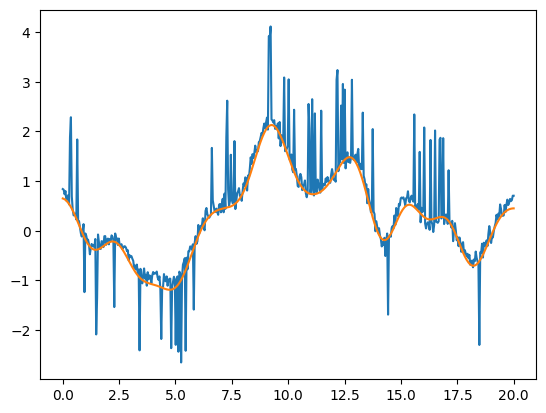

In [45]:
plt.plot(X,y)
plt.plot(X,model.mu_f)

SRCGP ALPHA


In [27]:
class GVI_SRCGPR_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing,kernel, sigma=1.,structure="Diag", alpha=0.5, test_size=0.1,weightfunction=w.IMQ,C=1.,objective="GVI"):
        super().__init__()
        self.X = tf.cast(X, tf.float64)  # [N, D]
        self.y = tf.cast(y, tf.float64)  # [N, 1]
        self.inducing_variable = tf.cast(inducing, tf.float64)
        self.N_u = inducing.shape[0]
        self.objective = objective
        # Variational and GP parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False,dtype=tf.float64)
        if structure == "Diag":
            self.Var_q = gpflow.Parameter([1.] * self.N_u, transform=gpflow.utilities.positive())
        else:
            self.Var_q = gpflow.Parameter(tf.linalg.eye(self.N_u), transform=gpflow.utilities.triangular())
        self.test_size = test_size
        self.structure = structure
        self.kernel = kernel
        self.lambda_i = 1.
        self.sigma = tf.Variable(sigma, dtype=tf.float64, trainable=False)
        self.kernel=kernel
        self.weightfunction = weightfunction(C=C)
        
    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
        
        
    @tf.function
    def train_step(self):
        if self.objective == "GVI":
            loss = self.GVI_step()
        else:
            loss = self.Pred_step()
        return loss

    def GVI_step(self):
        # Build kernel matrices
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        #weights
        m_y,J_w,J_w_inv=self.compute_weights(self.X,self.y)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)

        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @J_w@ K_fu @ K_uu_inv) / self.sigma ** 2 * self.lambda_i
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, J_w@(self.y-m_y)) / (self.sigma ** 2) * self.lambda_i
        # Compute mu_u
        mu_u = tf.matmul(q1, q2)

        # Log-determinants
        ld_K = tf.linalg.logdet(K_uu + jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u + jitter)

        # Loss components
        residual = self.y - K_fu @ K_uu_inv @ mu_u
        residual = tf.cast(residual, tf.float64)
        print(residual.dtype, self.sigma.dtype)
        T1 = K_uu_inv @ (K_uf @J_w@ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)

        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (
                        self.sigma ** -2) * self.lambda_i + 0.5 * self.lambda_i * (
                           N*tf.squeeze(self.kernel.variance)- tf.linalg.trace(T1) + tf.linalg.trace(
                            T2)) * self.lambda_i + N * tf.math.log(self.sigma)

        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u * (Sigma_a_inv @ mu_u))
        term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_u - self.alpha * ld_K)

        loss = term1 + term2 + term5
        
        self.sigma.assign(tf.squeeze(tf.sqrt(tf.transpose(y-K_fu@K_uu_inv@mu_u-m_y)@J_w_inv@(y-K_fu@K_uu_inv@mu_u-m_y)/tf.reduce_sum(J_w_inv))))
        
        return tf.squeeze(loss)

    def compute_weights(self,X,y):
        W_y=self.weightfunction.W(X, y)
        m_y= self.weightfunction.dy(X, y) ** 2
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, -2)))*self.sigma**2
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, 2)))/self.sigma**2
        return m_y,J_w,J_w_inv


    def predict_ins(self):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        # Constants
        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        
        #weight
        m_y,J_w,J_w_inv=self.compute_weights(self.X,self.y)

        # Invert via stable_solve
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        # Variational covariances
        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ J_w @ K_fu @ K_uu_inv)*self.sigma ** 2 * self.lambda_i
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, J_w@(self.y-m_y)) / (self.sigma ** 2) * self.lambda_i

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        K_uu = self.kernel(self.inducing_variable, self.inducing_variable)
        K_xu = self.kernel(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)

        K_uu_inv = tf.linalg.inv(K_uu)

             # compute variance
        f_var =self.kernel(Xnew, Xnew) - K_xu @ K_uu_inv  @ tf.transpose(
            K_xu) + K_xu @ K_uu_inv @ self.Sigma_u @ K_uu_inv @ tf.transpose(
            K_xu)

        return K_xu @ K_uu_inv @ self.mu_u,tf.linalg.diag_part(f_var)
    
    
    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.train_step, self.trainable_variables)

    def maximum_log_likelihood_objective(self):
        pass

    def sample_y(self, n_samples=100):
        N = self.X.shape[0]
        # compute the density of the sample based on q_u(\mu_u,\Sigma_u) and K
        noise = tf.random.normal(
                shape=(n_samples, N),
                mean=0.0,
                stddev=self.sigma,  # can be Parameter/Variable
                dtype=tf.float64
            )
        return f + noise

    def compute_lambda_stat(self, n_samples=100):
        y_sampl = self.sample_y(n_samples)
        #
        mu_f = self.predict_out(self.X)
        s = tf.reduce_mean(
            (y_sampl - mu_f) ** 2, axis=1)

        s_mean = tf.reduce_mean((self.y - mu_f) ** 2, axis=0)
        return tf.reduce_mean(tf.cast(s < s_mean, tf.float32))

    def pp_alg(self):
        lambda_values = [1., 0.1, 0.5, 0.7, 0.8, 0.9, 1.1, 1.2, 1.5, 2., 10.]
        test_values = []
        for lambda_i in lambda_values:
            self.lambda_i = lambda_i
            optimizer = gpflow.optimizers.Scipy()
            optimizer.minimize(self.train_step, self.trainable_variables)
            self.predict_ins()
            test_values.append(self.compute_lambda_stat())

        ##choose lambda with best
        self.lambda_i = lambda_values[test_values.index(min(test_values))]
        ##fit model with that lambda
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.train_step, self.trainable_variables)




In [30]:
N=X.shape[0]
Z =X[np.random.choice(N, 50, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
kernel=gpflow.kernels.SquaredExponential(1.,1.)
model = GVI_SRCGPR_alpha(X,y,inducing_variable,kernel)
model.internal_opt()
model.predict_ins()
model.predict_out(X)
plt.plot(X,y)
plt.plot(X[0:500:10],model.mu_u)

TypeError: Can't instantiate abstract class GVI_SRCGPR_alpha without an implementation for abstract method 'maximum_log_likelihood_objective'

In [36]:
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow

tfpk = tfp.math.psd_kernels

class GVI_SRCGPR_alpha(gpflow.models.BayesianModel):
    def __init__(self, X, y, inducing, sigma=1., structure="Diag", alpha=0.5,
                 test_size=0.1, weightfunction=None, C=1., objective="GVI"):
        super().__init__()
        self.X = tf.cast(X, tf.float64)
        self.y = tf.cast(y, tf.float64)
        self.inducing_variable = tf.cast(inducing, tf.float64)
        self.N_u = inducing.shape[0]
        self.objective = objective

        # Variational parameters
        self.alpha = gpflow.Parameter(alpha, trainable=False, dtype=tf.float64)
        if structure == "Diag":
            self.Var_q = gpflow.Parameter([1.] * self.N_u, transform=gpflow.utilities.positive())
        else:
            self.Var_q = gpflow.Parameter(tf.linalg.eye(self.N_u), transform=gpflow.utilities.triangular())
        self.structure = structure
        self.test_size = test_size

        # Kernel replaced with TFP ExponentiatedQuadratic
        self.kernel = tfpk.ExponentiatedQuadratic(
    amplitude=tf.constant(1.0, dtype=tf.float64),
    length_scale=tf.constant(1.0, dtype=tf.float64),
)


        # Other GP parameters
        self.lambda_i = 1.
        self.sigma = tf.Variable(sigma, dtype=tf.float64, trainable=False)
        self.weightfunction = weightfunction(C=C) if weightfunction is not None else None

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)

    def compute_weights(self, X, y):
        if self.weightfunction is None:
            N = X.shape[0]
            return tf.zeros([N, 1], dtype=tf.float64), tf.eye(N, dtype=tf.float64), tf.eye(N, dtype=tf.float64)
        W_y = self.weightfunction.W(X, y)
        m_y = self.weightfunction.dy(X, y)**2
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, -2))) * self.sigma**2
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(W_y, 2))) / self.sigma**2
        return m_y, J_w, J_w_inv

    @tf.function
    def train_step(self):
        if self.objective == "GVI":
            return self.GVI_step()
        else:
            return self.Pred_step()

    def GVI_step(self):
        K_uu = self.kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        N = tf.cast(tf.shape(self.X)[0], tf.float64)
        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)

        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        m_y, J_w, J_w_inv = self.compute_weights(self.X, self.y)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ J_w @ K_fu @ K_uu_inv) / self.sigma ** 2 * self.lambda_i
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, J_w @ self.y) / (self.sigma ** 2) * self.lambda_i
        mu_u = tf.matmul(q1, q2)

        residual = self.y - K_fu @ K_uu_inv @ mu_u
        T1 = K_uu_inv @ (K_uf @ J_w @ K_fu)
        T2 = T1 @ (K_uu_inv @ Sigma_u)
        
        #kernel diagonal, to specify if we change the kernel

        term1 = 0.5 * tf.reduce_sum(tf.square(residual)) * (self.sigma ** -2) * self.lambda_i
        term1 += 0.5 * self.lambda_i * (N * tf.squeeze(self.kernel.amplitude) - tf.linalg.trace(T1) + tf.linalg.trace(T2)) * self.lambda_i
        term1 += N * tf.math.log(self.sigma)

        term2 = 0.5 * self.alpha * tf.reduce_sum(mu_u * (Sigma_a_inv @ mu_u))

        ld_K = tf.linalg.logdet(K_uu + jitter)
        ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
        ld_Sig_u = tf.linalg.logdet(Sigma_u + jitter)
        term3 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_u - self.alpha * ld_K)

        self.sigma.assign(tf.squeeze(tf.sqrt(tf.transpose(self.y - K_fu @ K_uu_inv @ mu_u - m_y) @ J_w_inv @ (self.y - K_fu @ K_uu_inv @ mu_u - m_y) / tf.reduce_sum(J_w_inv))))

        return tf.squeeze(term1 + term2 + term3)

    def predict_ins(self):
        K_uu = self.kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_uf = self.kernel.matrix(self.inducing_variable, self.X)
        K_fu = tf.transpose(K_uf)

        jitter = tf.eye(self.N_u, dtype=tf.float64) * 1e-6
        K_uu_inv = tf.linalg.inv(K_uu + jitter)

        if self.structure == "Diag":
            Sigma_u = tf.linalg.diag(self.Var_q)
        else:
            Sigma_u = self.Var_q @ tf.transpose(self.Var_q)
        Sigma_a = self.alpha * K_uu + (1.0 - self.alpha) * Sigma_u
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)

        m_y, J_w, _ = self.compute_weights(self.X, self.y)

        precision_mid = self.alpha * Sigma_a_inv + (
                        K_uu_inv @ K_uf @ J_w @ K_fu @ K_uu_inv) / self.sigma ** 2 * self.lambda_i
        q1 = tf.linalg.inv(precision_mid + jitter)
        q2 = tf.matmul(K_uu_inv @ K_uf, J_w @ (self.y - m_y)) / (self.sigma ** 2) * self.lambda_i

        self.mu_u = tf.matmul(q1, q2)
        self.Sigma_u = Sigma_u

    def predict_out(self, Xnew):
        K_uu = self.kernel.matrix(self.inducing_variable, self.inducing_variable)
        K_xu = self.kernel.matrix(Xnew, self.inducing_variable)
        I_M = tf.eye(self.N_u, dtype=tf.float64)
        K_uu_inv = self.stable_solve(K_uu, I_M)

        f_var = self.kernel.matrix(Xnew, Xnew) - K_xu @ K_uu_inv @ tf.transpose(K_xu) + K_xu @ K_uu_inv @ self.Sigma_u @ K_uu_inv @ tf.transpose(K_xu)

        return K_xu @ K_uu_inv @ self.mu_u, tf.linalg.diag_part(f_var)

    def internal_opt(self, n_it=10):
        optimizer = tf.optimizers.Adam(learning_rate=0.01)
        for i in range(n_it):
            with tf.GradientTape(persistent=True) as tape:
                loss = self.train_step()
            grads = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.train_step, self.trainable_variables)
    def maximum_log_likelihood_objective(self):
        pass


In [38]:
N=X.shape[0]
Z =X[np.random.choice(N, 50, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=False)
model = GVI_SRCGPR_alpha(X,y,inducing_variable)
model.internal_opt()
model.predict_ins()
f,s=model.predict_out(X)
mu=f[0]


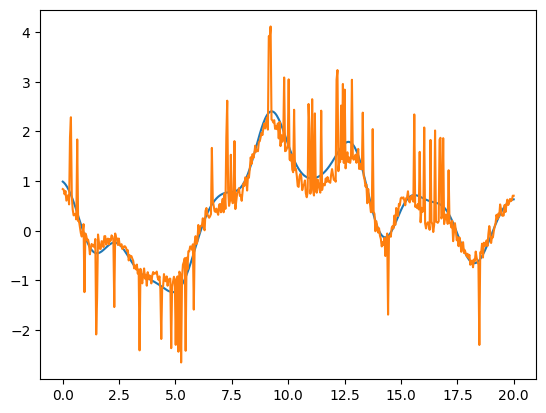

Laplace loss

Student loss

In [10]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_GP_T(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5,nu=2):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable=False)

        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(1., transform=gpflow.utilities.positive())
        
        self.nu=tf.constant(nu,dtype=tf.float64)
        self.lambda_inv=tf.Variable([1.]*X.shape[0],trainable=False,dtype=tf.float64)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    
    @tf.function
    def update_mu_f(self, Sigma_a_inv, sigma_2,Lambda_inv):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + Lambda_inv / sigma_2)
        q2 = tf.matmul(Lambda_inv / sigma_2, self.y)
        return tf.matmul(q1, q2)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    def predict_in(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        
        N = tf.cast(tf.shape(K)[0],tf.float64)
        print(N.dtype)
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Lambda_inv=tf.linalg.diag(self.lambda_inv)
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        self.mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)
        self.Sigma_f=Sigma_f
        
    def predict_out(self,X):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K_xold_xold = kernel.matrix(self.X, self.X)
        K_xold_xnew = kernel.matrix(X, self.X)
        jitter = 1e-6 * tf.eye(tf.shape(K_xold_xold)[0], dtype=K_xold_xold.dtype)
        K_inv = tf.linalg.inv(K_xold_xold + jitter)

        #compute variance
        f_var = kernel.matrix(X,X) - K_xold_xnew @ K_inv @ tf.transpose(K_xold_xnew)+ K_xold_xnew @ K_inv @ self.Sigma_f @ K_inv @ tf.transpose(K_xold_xnew)
        return K_xold_xnew @ K_inv @ self.mu_f, tf.linalg.diag_part(f_var)
    
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)

            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

            Sigma_f = K_fu @ K_uu_inv @ K_uf
            
            N = tf.cast(tf.shape(K)[0],tf.float64)
            print(N.dtype)
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            Lambda_inv=tf.linalg.diag(self.lambda_inv)
            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)

            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_f + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = 0.5 * self.sigma**(-2) * tf.transpose(mu_f) @ (Lambda_inv+Sigma_a_inv) @ mu_f
            term2 = -self.sigma**(-2) * tf.transpose(mu_f) @Lambda_inv @ (self.y)
            term3 = N* tf.math.log(self.sigma)
            term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Lambda_inv @ Sigma_f)
            term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2  + term3 + term4 + term5)

        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))

        # Update Lambda using current mu_f
        residual = self.y - mu_f
        num=self.nu+1
        denom=self.nu+tf.squeeze(residual)**2+tf.linalg.diag_part(Sigma_f)
        self.lambda_inv.assign(tf.squeeze((num / denom)))
         
        return loss
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        N = tf.cast(tf.shape(K)[0],tf.float64)
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Lambda_inv=tf.linalg.diag(self.lambda_inv)
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)
        return mu_f,Sigma_f

    def train(self, max_steps=500, tolerance=0.5, patience=5):
        loss_history = []
        steps_without_improvement = 0
        start_time = time.time()

        for step in range(max_steps):
            loss_val = self.train_step()
            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Training completed in {elapsed:.3f} seconds.")      

N=X.shape[0]
Z = X[np.random.choice(N, 70, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_GP_T(X, y,inducing_variable)
model.train()

<dtype: 'float64'>
<dtype: 'float64'>
Step: 0 Loss: 193.76173422327392
Step: 1 Loss: 213.3648362697762
Step: 2 Loss: 209.57481718148816
Step: 3 Loss: 203.92907421486356
Step: 4 Loss: 198.01925456150894
Step: 5 Loss: 192.01580704034103
Step: 6 Loss: 185.93519498854167
Step: 7 Loss: 179.78014637174076
Step: 8 Loss: 173.55034206246532
Step: 9 Loss: 167.24517701537204
Step: 10 Loss: 160.86269757603276
Step: 11 Loss: 154.3995744035259
Step: 12 Loss: 147.85086570939222
Step: 13 Loss: 141.20995270498042
Step: 14 Loss: 134.47063349211953
Step: 15 Loss: 127.62796078212955
Step: 16 Loss: 120.67868562669713
Step: 17 Loss: 113.62129511374565
Step: 18 Loss: 106.45451353366826
Step: 19 Loss: 99.17624087171214
Step: 20 Loss: 91.78321733251914
Step: 21 Loss: 84.27132624020794
Step: 22 Loss: 76.63624113429285
Step: 23 Loss: 68.8741693064784
Step: 24 Loss: 60.98204354996119
Step: 25 Loss: 52.95714987242343
Step: 26 Loss: 44.797524089203364
Step: 27 Loss: 36.499982373502405
Step: 28 Loss: 28.061807039141

<dtype: 'float64'>


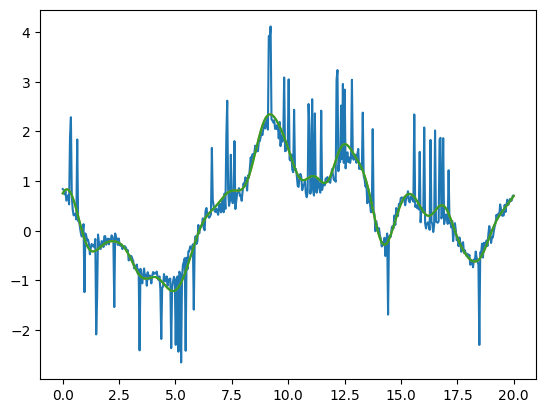

In [11]:
model.predict_in()
plt.plot(X,y)
plt.plot(X,model.mu_f)
plt.plot(X,model.predict_out(X)[0])

In [13]:
     
import time
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

class GVI_SGP_T(gpflow.models.BayesianModel):
    def __init__(self, X, y,inducing, alpha=0.5,nu=2):
        super().__init__()
        self.X = X
        self.y = y

        self.alpha = gpflow.Parameter(alpha,trainable=False)

        # GP parameters
        self.variance = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.lengthscale = gpflow.Parameter(1., transform=gpflow.utilities.positive())
        self.inducing_variable = inducing
        self.sigma=gpflow.Parameter(1., transform=gpflow.utilities.positive())
        
        self.nu=tf.constant(nu,dtype=tf.float64)
        self.lambda_inv=tf.Variable([1.]*X.shape[0],trainable=False,dtype=tf.float64)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    def stable_solve(self, mat, rhs):
        jitter = tf.eye(tf.shape(mat)[0], dtype=mat.dtype) * 1e-6
        L = tf.linalg.cholesky(mat + jitter)
        return tf.linalg.cholesky_solve(L, rhs)
    
    
    @tf.function
    def update_mu_f(self, Sigma_a_inv, sigma_2,Lambda_inv):
        q1 = tf.linalg.inv(self.alpha * Sigma_a_inv + Lambda_inv / sigma_2)
        q2 = tf.matmul(Lambda_inv / sigma_2, self.y)
        return tf.matmul(q1, q2)
    
    def maximum_log_likelihood_objective(self):
        pass
    
    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
            K = kernel.matrix(self.X, self.X)
            K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
            K_uf = kernel.matrix(self.inducing_variable, X)
            K_fu = tf.transpose(K_uf)

            K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

            Sigma_u = K_fu @ K_uu_inv @ K_uf
            
            N = tf.cast(tf.shape(K)[0],tf.float64)
            print(N.dtype)
            identity = tf.eye(N, dtype=K.dtype)
            jitter = identity * 1e-6
            K_j = K + jitter

            Lambda_inv=tf.linalg.diag(self.lambda_inv)
            Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_u
            Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
            mu_f = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)

            # Log-determinants
            ld_Sig_a = tf.linalg.logdet(Sigma_a + jitter)
            ld_Sig_f = tf.linalg.logdet(Sigma_u + jitter)
            ld_K = tf.linalg.logdet(K_j)

            # Loss terms
            term1 = 0.5 * self.sigma**(-2) * tf.transpose(mu_f) @ (Lambda_inv+Sigma_a_inv) @ mu_f
            term2 = -self.sigma**(-2) * tf.transpose(mu_f) @Lambda_inv @ (self.y)
            term3 = N* tf.math.log(self.sigma)
            term4 = 0.5 * self.sigma**(-2) * tf.linalg.trace(Lambda_inv @ Sigma_u)
            term5 = -1.0 / (2.0 * (self.alpha - 1.0)) * (ld_Sig_a + (self.alpha - 1.0) * ld_Sig_f - self.alpha * ld_K)
            loss = tf.squeeze(term1 + term2  + term3 + term4 + term5)

        # Trainable parameters
        

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads,  self.trainable_variables))

        # Update Lambda using current mu_f
        residual = self.y - mu_f
        num=self.nu+1
        denom=self.nu+tf.squeeze(residual)**2+tf.linalg.diag_part(Sigma_u)
        self.lambda_inv.assign(tf.squeeze((num / denom)))
         
        return loss
    
    def predict(self):
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(self.variance, self.lengthscale)
        K = kernel.matrix(self.X, self.X)
        K_uu = kernel.matrix(self.inducing_variable,self.inducing_variable)
        K_uf = kernel.matrix(self.inducing_variable, X)
        K_fu = tf.transpose(K_uf)

        K_uu_inv=tf.linalg.inv(K_uu+tf.linalg.eye(K_uu.shape[0],dtype=tf.float64)*gpflow.default_jitter())

        Sigma_f = K_fu @ K_uu_inv @ K_uf
        N = tf.cast(tf.shape(K)[0],tf.float64)
        identity = tf.eye(N, dtype=K.dtype)
        jitter = identity * 1e-6
        K_j = K + jitter

        Lambda_inv=tf.linalg.diag(self.lambda_inv)
        Sigma_a = self.alpha * K_j + (1.0 - self.alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a + jitter)
        mu_u = self.update_mu_f(Sigma_a_inv, self.sigma**2,Lambda_inv)
        return mu_u,Sigma_f

    def train(self, max_steps=500, tolerance=0.5, patience=5):
        loss_history = []
        steps_without_improvement = 0
        start_time = time.time()

        for step in range(max_steps):
            loss_val = self.train_step()
            loss_val = loss_val.numpy()
            loss_history.append(loss_val)

            tf.print("Step:", step, "Loss:", loss_val)

            if step > 0:
                loss_diff = abs(loss_history[-1] - loss_history[-2])
                if loss_diff < tolerance:
                    steps_without_improvement += 1
                else:
                    steps_without_improvement = 0

                if steps_without_improvement >= patience:
                    print(f"Early stopping at step {step}: loss change < {tolerance} for {patience} steps.")
                    break
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"Training completed in {elapsed:.3f} seconds.")      

N=X.shape[0]
Z = X[np.random.choice(N, 70, replace=False), :]
inducing_variable = gpflow.Parameter(Z,trainable=True)
model = GVI_SGP_T(X, y,inducing_variable)
model.train()

<dtype: 'float64'>
<dtype: 'float64'>
Step: 0 Loss: 193.11002460876557
Step: 1 Loss: 212.67947923452994
Step: 2 Loss: 208.89794108460345
Step: 3 Loss: 203.25910072615747
Step: 4 Loss: 197.35991766886272
Step: 5 Loss: 191.3726488598592
Step: 6 Loss: 185.3134137675567
Step: 7 Loss: 179.18114593350302
Step: 8 Loss: 172.97190019956184
Step: 9 Loss: 166.6824920248083
Step: 10 Loss: 160.31067850938012
Step: 11 Loss: 153.85442964607944
Step: 12 Loss: 147.3123553987562
Step: 13 Loss: 140.68283002933987
Step: 14 Loss: 133.96272351138526
Step: 15 Loss: 127.14993554026148
Step: 16 Loss: 120.23960409256506
Step: 17 Loss: 113.22707189216095
Step: 18 Loss: 106.10677830576753
Step: 19 Loss: 98.87235295641636
Step: 20 Loss: 91.51706233003591
Step: 21 Loss: 84.03366790153177
Step: 22 Loss: 76.41570585500205
Step: 23 Loss: 68.65827440184444
Step: 24 Loss: 60.758227691533534
Step: 25 Loss: 52.71468320055192
Step: 26 Loss: 44.528572365922685
Step: 27 Loss: 36.20118762774035
Step: 28 Loss: 27.7325386953538

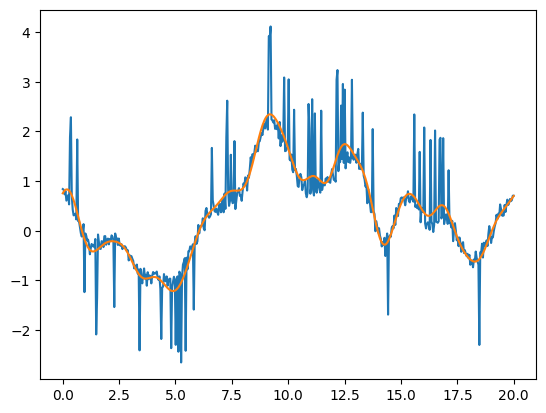

In [15]:
plt.plot(X,y)
plt.plot(X,model.predict()[0])